<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/LayoutLM/Fine_tuning_LayoutLMForSequenceClassification_on_RVL_CDIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to fine-tune `LayoutLMForSequenceClassification` on the [RVL-CDIP dataset](https://www.cs.cmu.edu/~aharley/rvl-cdip/), which is a document image classification task. Each scanned document in the dataset belongs to one of 16 classes, such as "resume" or "invoice" (so it's a multiclass classification problem). The entire dataset consists of no less than 400,000 (!) scanned documents. 

For demonstration purposes, we are going to fine-tune the model on a really small subset (one example per class), and verify whether the model is able to overfit them. Note that LayoutLM achieves state-of-the-art results on RVL-CDIP, with a classification accuracy of 94.42% on the test set.

* Original LayoutLM paper: https://arxiv.org/abs/1912.13318
* LayoutLM docs in the Transformers library: https://huggingface.co/transformers/model_doc/layoutlm.html


## Setting up environment

First, we install the 🤗 transformers and datasets libraries, as well as the [Tesseract OCR engine](https://github.com/tesseract-ocr/tesseract) (built by Google). LayoutLM requires an external OCR engine of choice to turn a document into a list of words and bounding boxes.

In [1]:
! pip install transformers datasets

In [2]:
! sudo apt install tesseract-ocr
! pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


## Getting the data

Next, we download a small subset of the RVL-CDIP dataset (which I prepared), containing 15 documents (one example per class). I omitted the "handwritten" class, because the OCR results were mediocre. 

In [3]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/kuw05qmc4uy474d/RVL_CDIP_one_example_per_class.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Let's look at a random training example (in this case, a resume):

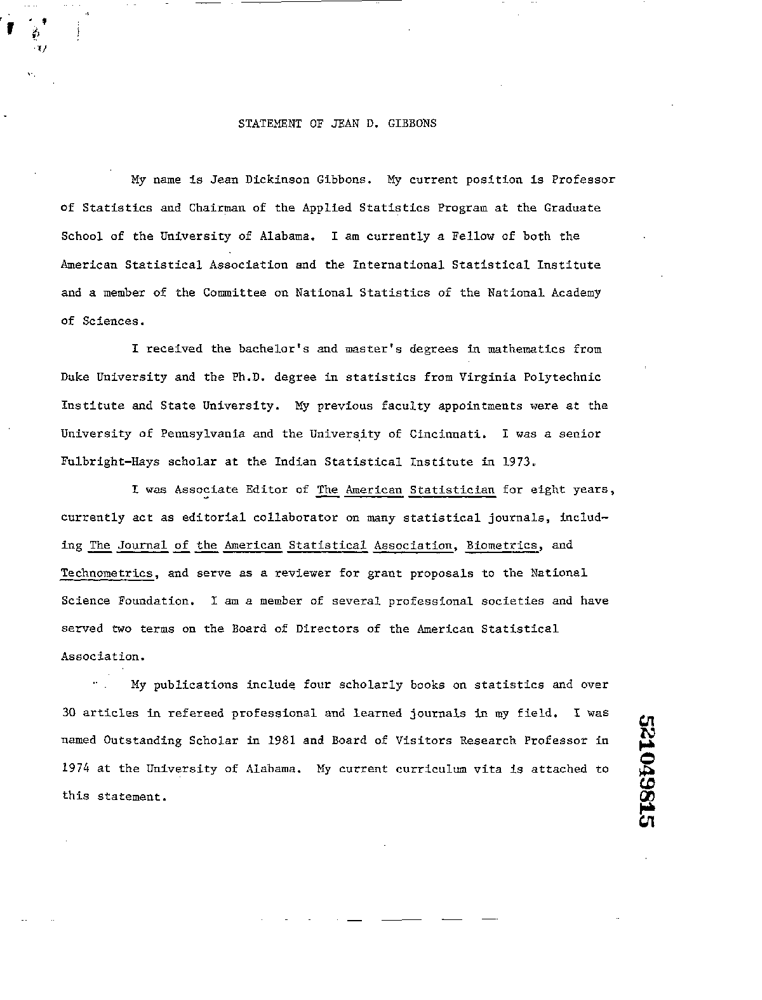

In [4]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/RVL_CDIP_one_example_per_class/resume/0000157402.tif")
image = image.convert("RGB")
image

We can use the Tesseract OCR engine to turn the image into a list of recognized words:

In [5]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

"ot uv STATEMENT OF JEAN D, GIBBONS My name 4s Jean Dickinson Gibbons. My current position is Professor of Statistics and Chairman of the Applied Statistics Program at the Graduate School of the University of Alabana, I am currently a Fellow of both the American Statistical Association and the International Statistical Institute and a menber of the Committee on National Statistics of the National, Acadeny of Scdences. I received the bachelor's and master's degrees in mathematics from Duke University and the Ph.D. degree in statistics from Virginia Polytechnic Institute and State University. My previous faculty appointments were at the University of Pennsylvania and the University of Cincinnati. I was a senior Fulbright-Hays scholar at the Indian Statistical Institute in 1973. Twas Associate Editor of The Anertcan Statistician for eight years, currently act as editortal collaborator on many statistical journals, includ~ Technometrics, and serve as a reviewer for grant proposals to the N

We can also visualize the bounding boxes of the recognized words, as follows:

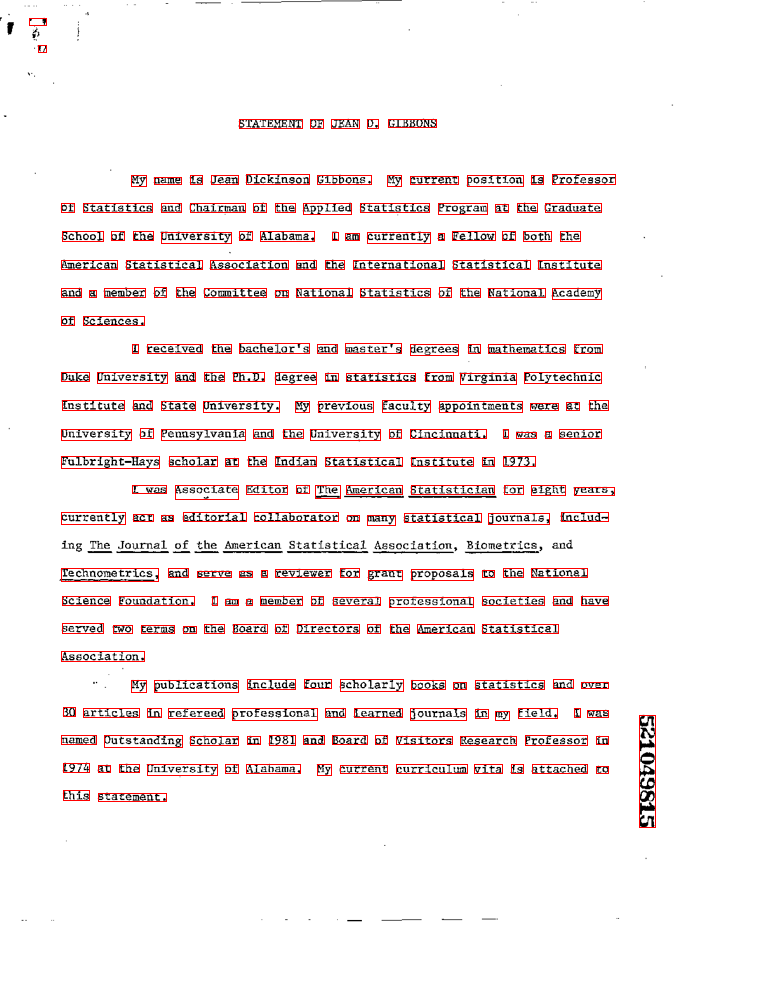

In [6]:
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
    x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
    actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
    actual_boxes.append(actual_box)

draw = ImageDraw.Draw(image, "RGB")
for box in actual_boxes:
  draw.rectangle(box, outline='red')

image

## Preprocessing the data using 🤗 datasets

First, we convert the dataset into a Pandas dataframe, having 2 columns: `image_path` and `label`.

In [7]:
import pandas as pd
import os

dataset_path = "/content/RVL_CDIP_one_example_per_class"
labels = [label for label in os.listdir(dataset_path)]
idx2label = {v: k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}
label2idx

{'advertisement': 4,
 'budget': 6,
 'email': 13,
 'file_folder': 10,
 'form': 9,
 'invoice': 3,
 'letter': 11,
 'memo': 8,
 'news_article': 12,
 'presentation': 1,
 'questionnaire': 5,
 'resume': 7,
 'scientific_publication': 14,
 'scientific_report': 2,
 'specification': 0}

In [8]:
images = []
labels = []

for label_folder, _, file_names in os.walk(dataset_path):
  if label_folder != dataset_path:
    label = label_folder[40:]
    for _, _, image_names in os.walk(label_folder):
      relative_image_names = []
      for image in image_names:
        relative_image_names.append(dataset_path + "/" + label + "/" + image)
      images.extend(relative_image_names)
      labels.extend([label] * len (relative_image_names)) 

data = pd.DataFrame.from_dict({'image_path': images, 'label': labels})
data.head()

,image_path,label
0,/content/RVL_CDIP_one_example_per_class/specif...,specification
1,/content/RVL_CDIP_one_example_per_class/presen...,presentation
2,/content/RVL_CDIP_one_example_per_class/scient...,scientific_report
3,/content/RVL_CDIP_one_example_per_class/invoic...,invoice
4,/content/RVL_CDIP_one_example_per_class/advert...,advertisement


In [9]:
len(data)

15

Now, let's apply OCR to get the words and bounding boxes of every image. To do this efficiently, we turn our Pandas dataframe into a HuggingFace `Dataset` object, and use the `.map()` functionality to get the words and normalized bounding boxes of every image. Note that this can take a while to run (Tesseract seems a bit slow).

In [10]:
from datasets import Dataset

def normalize_box(box, width, height):
     return [
         int(1000 * (box[0] / width)),
         int(1000 * (box[1] / height)),
         int(1000 * (box[2] / width)),
         int(1000 * (box[3] / height)),
     ]

def apply_ocr(example):
        # get the image
        image = Image.open(example['image_path'])

        width, height = image.size
        
        # apply ocr to the image 
        ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
        float_cols = ocr_df.select_dtypes('float').columns
        ocr_df = ocr_df.dropna().reset_index(drop=True)
        ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
        ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
        ocr_df = ocr_df.dropna().reset_index(drop=True)

        # get the words and actual (unnormalized) bounding boxes
        #words = [word for word in ocr_df.text if str(word) != 'nan'])
        words = list(ocr_df.text)
        words = [str(w) for w in words]
        coordinates = ocr_df[['left', 'top', 'width', 'height']]
        actual_boxes = []
        for idx, row in coordinates.iterrows():
            x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
            actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
            actual_boxes.append(actual_box)
        
        # normalize the bounding boxes
        boxes = []
        for box in actual_boxes:
            boxes.append(normalize_box(box, width, height))
        
        # add as extra columns 
        assert len(words) == len(boxes)
        example['words'] = words
        example['bbox'] = boxes
        return example

dataset = Dataset.from_pandas(data)
updated_dataset = dataset.map(apply_ocr)

Next, we can turn the word-level 'words' and 'bbox' columns into token-level `input_ids`, `attention_mask`, `bbox` and `token_type_ids` using `LayoutLMTokenizer`.

In [11]:
from transformers import LayoutLMTokenizer
import torch

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

def encode_example(example, max_seq_length=512, pad_token_box=[0, 0, 0, 0]):
  words = example['words']
  normalized_word_boxes = example['bbox']

  assert len(words) == len(normalized_word_boxes)

  token_boxes = []
  for word, box in zip(words, normalized_word_boxes):
      word_tokens = tokenizer.tokenize(word)
      token_boxes.extend([box] * len(word_tokens))
  
  # Truncation of token_boxes
  special_tokens_count = 2 
  if len(token_boxes) > max_seq_length - special_tokens_count:
      token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
  
  # add bounding boxes of cls + sep tokens
  token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]
  
  encoding = tokenizer(' '.join(words), padding='max_length', truncation=True)
  # Padding of token_boxes up the bounding boxes to the sequence length.
  input_ids = tokenizer(' '.join(words), truncation=True)["input_ids"]
  padding_length = max_seq_length - len(input_ids)
  token_boxes += [pad_token_box] * padding_length
  encoding['bbox'] = token_boxes
  encoding['label'] = label2idx[example['label']]

  assert len(encoding['input_ids']) == max_seq_length
  assert len(encoding['attention_mask']) == max_seq_length
  assert len(encoding['token_type_ids']) == max_seq_length
  assert len(encoding['bbox']) == max_seq_length

  return encoding

In [12]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D

# we need to define the features ourselves as the bbox of LayoutLM are an extra feature
features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'label': ClassLabel(names=['refuted', 'entailed']),
    'image_path': Value(dtype='string'),
    'words': Sequence(feature=Value(dtype='string')),
})

encoded_dataset = updated_dataset.map(lambda example: encode_example(example), 
                                      features=features)

Finally, we set the format to PyTorch, as the LayoutLM implementation in the Transformers library is in PyTorch. We also specify which columns we are going to use.

In [13]:
encoded_dataset.set_format(type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])

In [14]:
dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=1, shuffle=True)
batch = next(iter(dataloader))
batch

/usr/local/lib/python3.6/dist-packages/datasets/arrow_dataset.py:851: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.tensor(x, **format_kwargs)


{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

Let's verify whether the input ids are created correctly by decoding them back to text:

In [15]:
tokenizer.decode(batch['input_ids'][0].tolist())

'[CLS] tr, rh, griffith ( ) de. re 2. jobaisen / oja 8 february 1963, chromatography of arona concentrates 38 oer continuing : investigations on the separation of tobacco acum con = sgakeace constituents ws have found that columa clioaatograply of evade aren see pence on ilies gol ie excellene tor their initial fractlostions tate ‘ hee becona the basis for an improved isolation schema for cossovod a experinental suey of 23 - 70 mash silica gel iu hexane is added to a 1 em coluen untid sre atticn sol bed depth 1s 39 eu. a 2. 0 ¢ gample af a erude hgh eeopecacuee seagjcekemerate 48 then applied eo the top of the coluan in hexane, eluring je rsefemplisted ftree with hexane, and then with solvents of gradwally increasing poreritys, rections of 100 mi are collegtad and tho weights of eluted arenes of the flaereceat soven : renoval at 20° / 10 axe mesules fron the chrouatastapiy 7 of the flue - eured sud burley aruna concentrates are tabulated belove burley fluo - cured ee reaction ¢ solvent

In [16]:
idx2label[batch['label'][0].item()]

'memo'

## Define the model

Here we define the model, namely `LayoutLMForSequenceClassification`. We initialize it with the weights of the pre-trained base model (`LayoutLMModel`). The weights of the classification head are randomly initialized, and will be fine-tuned together with the weights of the base model on our tiny dataset. Once loaded, we move it to the GPU.



In [17]:
from transformers import LayoutLMForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForSequenceClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(label2idx))
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForSequenceClassification were not initialized from the model checkpoint 

LayoutLMForSequenceClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
      

## Train the model

Here we train the model in familiar PyTorch fashion. We use the Adam optimizer with weight decay fix (normally you can also specify which variables should have weight decay and which not + a learning rate scheduler, see [here](https://github.com/microsoft/unilm/blob/5d16c846bec56b6e88ec7de4fc3ceb7c803571a4/layoutlm/examples/classification/run_classification.py#L94) for how the authors of LayoutLM did this), and train for 30 epochs. If the model is able to overfit it, then it means there are no issues and we can train it on the entire dataset.

In [18]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 30
t_total = len(dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  running_loss = 0.0
  correct = 0
  for batch in dataloader:
      input_ids = batch["input_ids"].to(device)
      bbox = batch["bbox"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      token_type_ids = batch["token_type_ids"].to(device)
      labels = batch["label"].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      running_loss += loss.item()
      predictions = outputs.logits.argmax(-1)
      correct += (predictions == labels).float().sum()

      # backward pass to get the gradients 
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1
  
  print("Loss:", running_loss / batch["input_ids"].shape[0])
  accuracy = 100 * correct / len(data)
  print("Training accuracy:", accuracy.item())

Epoch: 0
Loss: 43.12694573402405
Training accuracy: 0.0
Epoch: 1
Loss: 35.339784145355225
Training accuracy: 33.333335876464844
Epoch: 2
Loss: 30.55066680908203
Training accuracy: 86.66667175292969
Epoch: 3
Loss: 27.842902660369873
Training accuracy: 86.66667175292969
Epoch: 4
Loss: 21.45477443933487
Training accuracy: 100.00000762939453
Epoch: 5
Loss: 19.765377640724182
Training accuracy: 93.33333587646484
Epoch: 6
Loss: 16.269045293331146
Training accuracy: 93.33333587646484
Epoch: 7
Loss: 13.61208951473236
Training accuracy: 100.00000762939453
Epoch: 8
Loss: 12.580875396728516
Training accuracy: 100.00000762939453
Epoch: 9
Loss: 9.917366653680801
Training accuracy: 100.00000762939453
Epoch: 10
Loss: 8.083266794681549
Training accuracy: 100.00000762939453
Epoch: 11
Loss: 8.36630928516388
Training accuracy: 93.33333587646484
Epoch: 12
Loss: 7.368062764406204
Training accuracy: 93.33333587646484
Epoch: 13
Loss: 5.720428228378296
Training accuracy: 100.00000762939453
Epoch: 14
Loss: 4.6

## Legacy

The code below was used during the creation of this notebook, but is now not used anymore.

In [19]:
import torch

def convert_example_to_features(image, words, boxes, actual_boxes, tokenizer, max_seq_length=512, cls_token_box=[0, 0, 0, 0],
                                 sep_token_box=[1000, 1000, 1000, 1000],
                                 pad_token_box=[0, 0, 0, 0]):
      width, height = image.size

      tokens = []
      token_boxes = []
      actual_bboxes = [] # we use an extra b because actual_boxes is already used
      token_actual_boxes = []
      for word, box, actual_bbox in zip(words, boxes, actual_boxes):
          word_tokens = tokenizer.tokenize(word)
          tokens.extend(word_tokens)
          token_boxes.extend([box] * len(word_tokens))
          actual_bboxes.extend([actual_bbox] * len(word_tokens))
          token_actual_boxes.extend([actual_bbox] * len(word_tokens))

      # Truncation: account for [CLS] and [SEP] with "- 2". 
      special_tokens_count = 2 
      if len(tokens) > max_seq_length - special_tokens_count:
          tokens = tokens[: (max_seq_length - special_tokens_count)]
          token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
          actual_bboxes = actual_bboxes[: (max_seq_length - special_tokens_count)]
          token_actual_boxes = token_actual_boxes[: (max_seq_length - special_tokens_count)]

      # add [SEP] token, with corresponding token boxes and actual boxes
      tokens += [tokenizer.sep_token]
      token_boxes += [sep_token_box]
      actual_bboxes += [[0, 0, width, height]]
      token_actual_boxes += [[0, 0, width, height]]
      
      segment_ids = [0] * len(tokens)

      # next: [CLS] token
      tokens = [tokenizer.cls_token] + tokens
      token_boxes = [cls_token_box] + token_boxes
      actual_bboxes = [[0, 0, width, height]] + actual_bboxes
      token_actual_boxes = [[0, 0, width, height]] + token_actual_boxes
      segment_ids = [1] + segment_ids

      input_ids = tokenizer.convert_tokens_to_ids(tokens)

      # The mask has 1 for real tokens and 0 for padding tokens. Only real
      # tokens are attended to.
      input_mask = [1] * len(input_ids)

      # Zero-pad up to the sequence length.
      padding_length = max_seq_length - len(input_ids)
      input_ids += [tokenizer.pad_token_id] * padding_length
      input_mask += [0] * padding_length
      segment_ids += [tokenizer.pad_token_id] * padding_length
      token_boxes += [pad_token_box] * padding_length
      token_actual_boxes += [pad_token_box] * padding_length

      assert len(input_ids) == max_seq_length
      assert len(input_mask) == max_seq_length
      assert len(segment_ids) == max_seq_length
      assert len(token_boxes) == max_seq_length
      assert len(token_actual_boxes) == max_seq_length
      
      encoding = {}
      
      encoding["input_ids"] = torch.tensor(input_ids)
      encoding["bbox"] = torch.tensor(token_boxes)
      encoding["attention_mask"] = torch.tensor(input_mask)
      encoding["token_type_ids"] = torch.tensor(segment_ids)

      return encoding

In [20]:
from torch.utils.data import Dataset, DataLoader
import pytesseract
import numpy as np

class Dataset(Dataset):
    """RVL-CDIP dataset (small subset)."""

    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get the image
        image = Image.open(data.iloc[idx].image_path)

        width, height = image.size
        
        # apply ocr to the image 
        ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
        float_cols = ocr_df.select_dtypes('float').columns
        ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
        ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
        ocr_df = ocr_df.dropna().reset_index(drop=True)

        # get the words and actual (unnormalized) bounding boxes
        words = list(ocr_df.text)
        coordinates = ocr_df[['left', 'top', 'width', 'height']]
        actual_boxes = []
        for idx, row in coordinates.iterrows():
            x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
            actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box 
            actual_boxes.append(actual_box)
        
        # normalize the bounding boxes
        boxes = []
        for box in actual_boxes:
            boxes.append(normalize_box(box, width, height))

        # convert to token-level features
        encoding = convert_example_to_features(image, words, boxes, actual_boxes, self.tokenizer)

        # add the label
        print(idx)
        label = data.iloc[idx].label
        encoding["label"] = torch.tensor(label2idx[label])
        
        return encoding